# Dyna and Dyna-Q+ implementations and results

In this notebook I implement the Dyna and Dyna-Q+ algorithms and use them in conjunction with a flexible gridworld environment (which lets you alter the goal states, obstacles, and starting positions). I run some experiments that are loosely based off the ones that Sutton presented in this book (Chapter 8).

In [1]:
import itertools
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
np.random.seed(0)
import itertools

[2017-03-29 18:34:21,067] You have 'numpy' version 1.10.1 installed, but 'gym' requires at least 1.10.4. HINT: upgrade via 'pip install -U numpy'.


## The maze environment

This is an OpenAI gym implementation of the maze environment in the planning chapter of Sutton's book. This class is flexible in the sense that are you able to define where the start state and goal states are, and also where the obstacles are. This allows us to test a wide range of environments against planning algorithms.

In [2]:
class Maze(discrete.DiscreteEnv):
    metadata = {'render.modes':['human','ansi']}
    
    def _yx_to_linear(self,i,j):
        """
        :i: height index
        :j: width index
        """
        return i*self.width + j
    
    def _linear_to_yx(self, s):
        return s
    
    def __init__(self, shape, goal, start_state=(2,0), obstacles=[]):
        """
        :shape: a tuple of shape (height, width)
        :goal a tuple (i,j) (zero-indexed), (zero-indexed),
          where `i` indexes the column and `j` the row 
        :obstacles: a list of tuples (i,j) similar to above
        """
        self.shape = shape
        self.height, self.width = self.shape
        nS = np.prod(self.shape)
        self.obstacles = set()
        for tp in obstacles:
            self.obstacles.add( self._yx_to_linear(tp[0],tp[1]) )
        self.goal_state = self._yx_to_linear(*goal)
        nA = 4
        # calculate transition probabilities
        self.LEFT, self.UP, self.RIGHT, self.DOWN = 0, 1, 2, 3
        # (prob, new_state, reward, is_done)
        P = {}
        for i in range(self.height):
            for j in range(self.width):
                # i,j indexes width,height
                s = self._yx_to_linear(i,j)
                P[s] = {a : [] for a in range(nA) }
                # if we are at the left boundary, we can't go anymore left
                left = self._yx_to_linear(i, j-1)
                if j == 0 or left in self.obstacles:
                    P[s][self.LEFT] = [(1.0, s, 0, False)]
                else:
                    r, is_done = 1 if left == self.goal_state else 0, True if left == self.goal_state else False
                    P[s][self.LEFT] = [(1.0, left, r, is_done)]
                    
                # if we are at the right boundary, we can't go anymore right
                right = self._yx_to_linear(i, j+1)
                if j == (self.width-1) or right in self.obstacles:
                    P[s][self.RIGHT] = [(1.0, s, 0, False)]
                else:
                    r, is_done = 1 if right == self.goal_state else 0, True if right == self.goal_state else False
                    P[s][self.RIGHT] = [(1.0, right, r, is_done)]
                    
                # if we are at the top boundary, we can't go anymore top
                up = self._yx_to_linear(i-1, j)
                if i == 0 or up in self.obstacles:
                    P[s][self.UP] = [(1.0, s, 0, False)]
                else:
                    r, is_done = 1 if up == self.goal_state else 0, True if up == self.goal_state else False
                    P[s][self.UP] = [(1.0, up, r, is_done)]
                    
                # if we are at the bottom boundary, we can't go anymore bottom
                down = self._yx_to_linear(i+1, j)
                if i == (self.height-1) or down in self.obstacles:
                    P[s][self.DOWN] = [(1.0, s, 0, False)]
                else:
                    r, is_done = 1 if down == self.goal_state else 0, True if down == self.goal_state else False
                    P[s][self.DOWN] = [(1.0, down, r, is_done)]
                    
        self.P = P
        
        # we always start in state C (which is 3)
        isd = np.zeros(nS)
        isd[ self._yx_to_linear(start_state[0],start_state[1]) ] = 1.0
        
        super(Maze, self).__init__(nS, nA, P, isd)
    
    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        game = [ ['o']*self.width ] * self.height
        
        for i in range(self.height):
            for j in range(self.width):
                if self._yx_to_linear(i,j) == self.s:
                    outfile.write("x" + " ")
                elif self._yx_to_linear(i,j) in self.obstacles:
                    outfile.write("X" + " ")
                elif self._yx_to_linear(i,j) == self.goal_state:
                    outfile.write("G" + " ")
                else:
                    outfile.write(game[i][j] + " ")
            outfile.write("\n")
        
        #st = ['LT', 'A', 'B', 'C', 'D', 'E', 'RT']
        #st[self.s] = '(' + st[self.s] + ')'
        #outfile.write(" ".join(st))
        #outfile.write("\n")

In [3]:
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3

## Dyna-Q

Here is the pseudocode of tabular Dyna-Q. We implement it here. Note that, for the sake of not having code duplication, the below implementation will also include code that is relevant for Dyna-Q+ (which is the second thing we look at), but hopefully that won't skew the the presentation of Dyna-Q code.

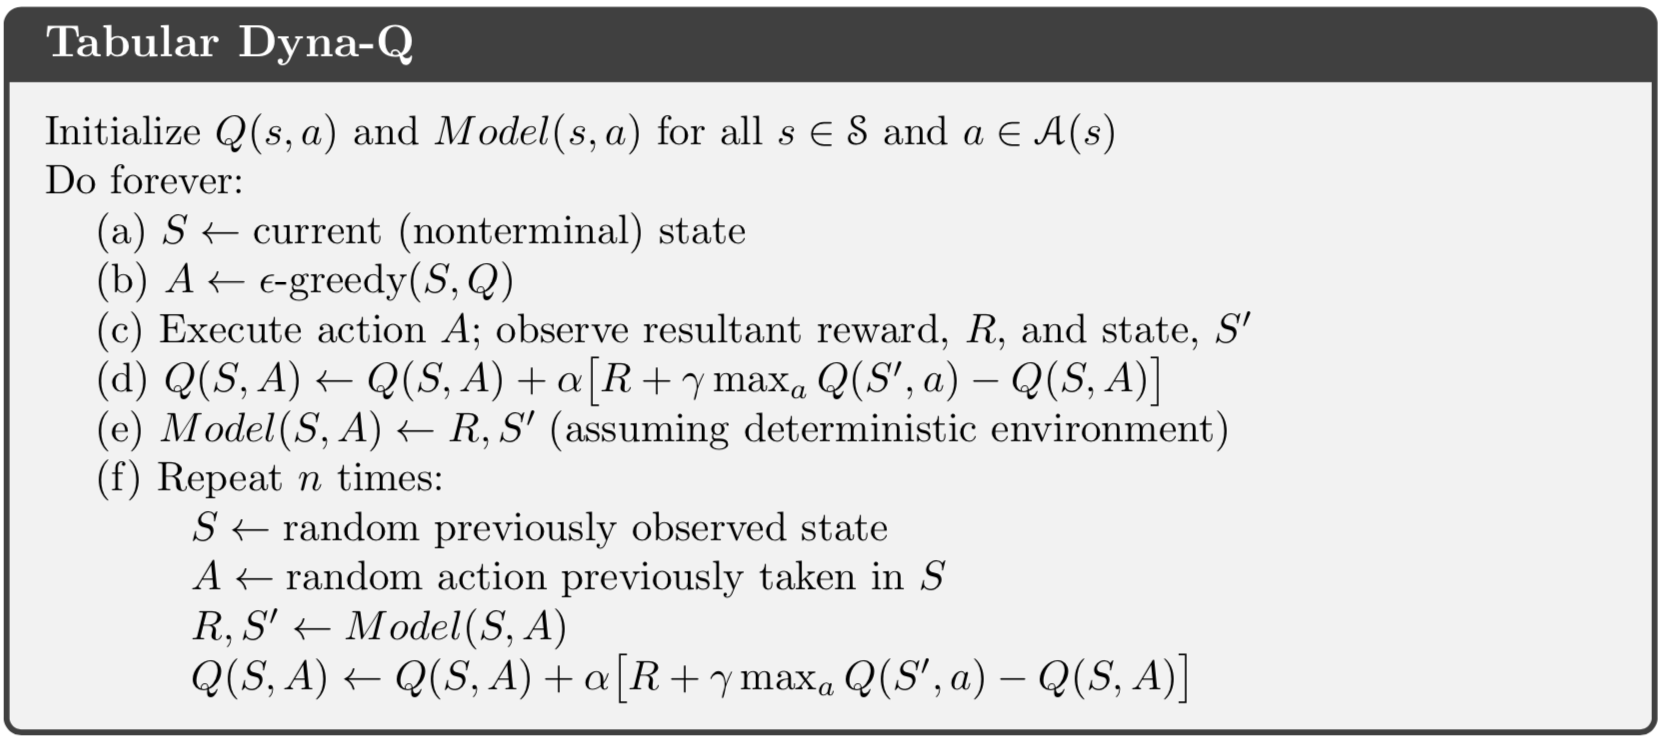

In [4]:
Image("./tabular_dyna.png", width=800)

In [5]:
def Q_to_eps_greedy_policy(Q, eps=0.1):
    num_actions = Q.shape[1]
    # mapping from states -> actions
    pi = np.zeros(Q.shape[0],)
    for i in range(0, Q.shape[0]):
        if np.random.uniform(0,1) < eps:
            # choose a random action
            pi[i] = np.random.randint(0, num_actions)
        else:
            # take the argmax of Q[s,.]
            # this does random tie breaking in the event of 
            # multiple indices with the highest Q value
            max_idxs = np.argwhere(Q[i] == np.max(Q[i])).flatten()
            np.random.shuffle(max_idxs)
            pi[i] = int(max_idxs[0])
    return pi

In [6]:
def q_learning(env, num_eps, epsilon, model_n, alpha, gamma=1.0, 
               kappa=0., new_env=None, switch_env_after=0, kappa_action_select=False):
    """
    :env: OpenAI environment
    :num_eps: number of episodes
    :epsilon: epsilon
    :model_n: number of times per iter that we update Q with simulated
      experience
    :alpha: learning rate
    :gamma: discount factor
    :kappa: (DYNA-Q+ ONLY) exploration reward factor
    :new_env: (DYNA-Q+ ONLY) if `switch_env_after` is != 0, then after `switch_env_after`
      episodes we will switch the environment to this new environment.
    :switch_env_after: (DYNA-Q+ ONLY) switch to the new environment after this many
      episodes have elapsed
    :kappa_action_select: (DYNA-Q+ only) if true, then we use the suggested change in Exercise 8.4
      (Sutton book) where we use kappa*sqrt(t) factor to select an action, rather than
      use it in Q-learning
    """
    def best_action(Q, S_prime):
        # we want to find argmax_a Q[S_prime, a]
        Q_as = []
        for a in range(env.nA):
            Q_as.append(Q[S_prime,a])
        A_max = np.argmax(Q_as)
        return A_max
    Q = np.zeros((env.nS, env.nA))
    reward_sums = []
    eps_lengths = []
    # model is a mapping from (s,a) to (r,s')
    model = {}
    # we keep track of the last time step when we made the
    # (state,action) transition
    track_time = np.zeros((env.nS, env.nA))
    tot_steps = 0
    for num_ep in range(num_eps):
        #print num_ep,
        eps_length = 0
        reward_sum = 0
        if switch_env_after > 0 and switch_env_after == num_ep:
            print "episode %i, switching env to new env" % (num_ep+1)
            env = new_env
        env.reset()
        # initialise S
        S = env.s
        # repeat, for each step of episode
        for timestep in itertools.count():
            tot_steps += 1
            # choose A from S using policy derived from Q (e.g. eps-greedy)
            if kappa > 0 and kappa_action_select:
                # NOTE: this only applies to Dyna-Q+
                pi = Q_to_eps_greedy_policy(Q + (kappa*np.sqrt(tot_steps-track_time)), eps=epsilon)
            else:
                pi = Q_to_eps_greedy_policy(Q, eps=epsilon)
            A = pi[S]
            # if we are using dyna-Q+, save the time step when we took this action
            track_time[S,A] = tot_steps
            # take action A, observe R, S'
            _, R, is_done, _ = env.step(A)
            reward_sum += R
            eps_length += 1
            S_prime = env.s
            A_max = best_action(Q,S_prime)
            Q[S,A] = Q[S,A] + alpha*(R + (gamma*Q[S_prime,A_max]) - Q[S,A])
            model[(S,A)] = (R,S_prime)
            S = S_prime
            eps_length += 1
            if is_done:
                break
            keys = model.keys()
            for n in range(model_n):
                keys = model.keys()
                rnd_idx = np.random.randint(0,len(keys))
                #print "rnd_idx", rnd_idx
                #print "keys", keys
                sim_S,sim_A = keys[rnd_idx]
                sim_R,sim_S_prime = model[keys[rnd_idx]]
                if kappa > 0:
                    # NOTE: this only applies to Dyna-Q+
                    time_elapsed = tot_steps - track_time[sim_S,sim_A] + 1
                    if not kappa_action_select:
                        sim_R += kappa*np.sqrt(time_elapsed)
                    #if time_elapsed < 0:
                    #    print num_ep+1, timestep+1, track_time[sim_S,sim_A]
                sim_A_max = best_action(Q,sim_S_prime)
                Q[sim_S,sim_A] = Q[sim_S,sim_A] + alpha*(sim_R + (gamma*Q[sim_S_prime,sim_A_max]) - Q[sim_S,sim_A])
        #print "eps length:", eps_length
        reward_sums.append(reward_sum)
        eps_lengths.append(eps_length)
    return Q, reward_sums, eps_lengths

Let's replicate the experiment from the book with the exact same maze specification. In this experiment, they simply show that convergence to the optimal Q function happens a lot faster when we sample from simulated experience.

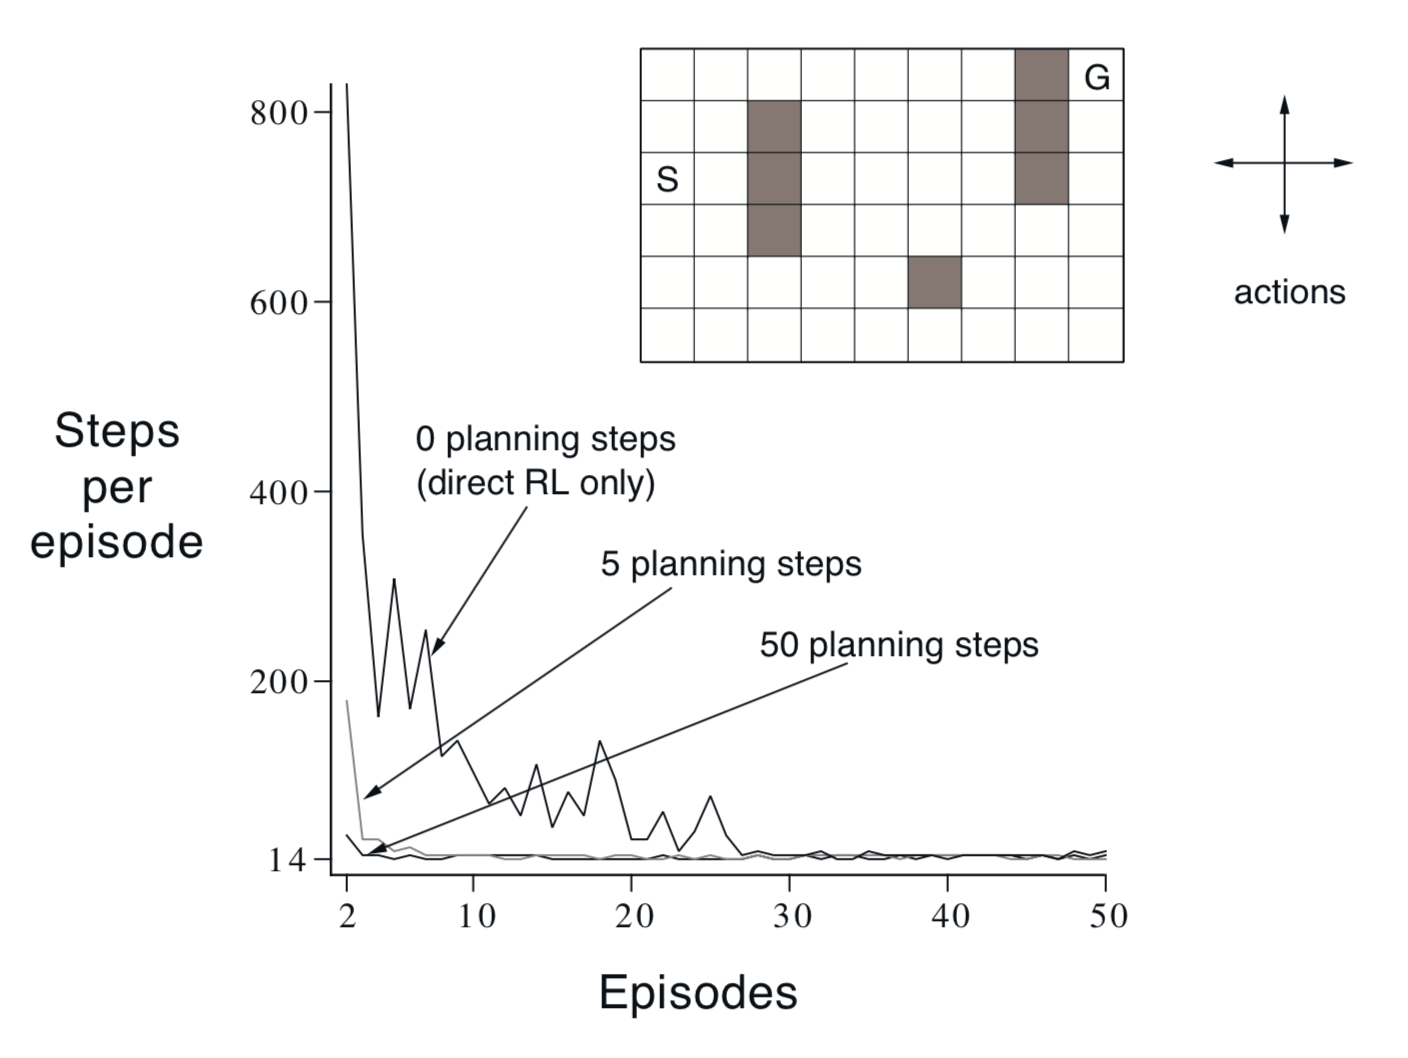

In [7]:
Image("./dyna_maze1.png", width=600)

We now instantiate a version of the maze environment just like the above image. For reference, `x` denotes the agent, `X` denotes obstacle, and `G` denotes goal.

In [8]:
obstacles=[(1,2),(2,2),(3,2),(4,5),(0,7),(1,7),(2,7)]
env = Maze(shape=(7,9), obstacles=obstacles, goal=(0,8))
env.render()

o o o o o o o X G 
o o X o o o o X o 
x o X o o o o X o 
o o X o o o o o o 
o o o o o X o o o 
o o o o o o o o o 
o o o o o o o o o 


Let's run no planning (direct RL) ten times, average the episode lengths, then plot.

In [9]:
def repeat_experiment(env, num_reps, **kwargs):
    lengths = []
    qs = np.zeros((env.nS, env.nA))
    for i in range(num_reps):
        np.random.seed(i)
        env.reset()
        this_q, _, eps_lengths = q_learning(env, **kwargs)
        lengths.append(eps_lengths)
        qs += this_q
    lengths = np.asarray(lengths)
    lengths = np.sum(lengths,axis=0) / lengths.shape[0]
    qs = qs / num_reps
    return lengths, qs

In [10]:
eps_lengths1, q1 = repeat_experiment(env, 
    num_reps=10, num_eps=100, epsilon=0.1, alpha=0.1, model_n=0, gamma=0.95)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


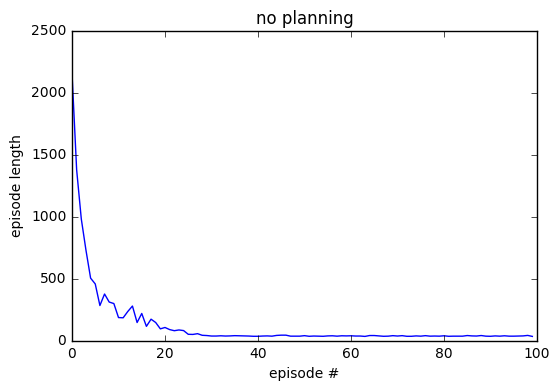

In [11]:
plt.plot(eps_lengths1)
plt.xlabel("episode #")
plt.ylabel("episode length")
plt.title("no planning")

We can also visualise the best action to take for each state, which is good to also verify that our Q-learning algorithm is working as intended.

In [14]:
def action_grid(env, q, ignore=[]):
    best_actions = []
    adt = {LEFT:"<<", UP:"^^", RIGHT:">>", DOWN:"vv"}
    for row in q:
        best_actions.append(adt[np.argmax(row)])
    best_actions = np.asarray(best_actions)
    best_actions = best_actions.reshape(env.shape)
    for tp in ignore:
        best_actions[ tp[0], tp[1] ] = "XX"
    return best_actions

In [15]:
action_grid(env, q1, obstacles)

array([['>>', '>>', '>>', 'vv', 'vv', 'vv', 'vv', 'XX', '<<'],
       ['^^', '^^', 'XX', '>>', '>>', 'vv', 'vv', 'XX', '^^'],
       ['vv', 'vv', 'XX', '>>', '>>', '>>', 'vv', 'XX', '^^'],
       ['>>', 'vv', 'XX', '>>', '>>', '>>', '>>', '>>', '^^'],
       ['>>', '>>', '>>', '>>', '^^', 'XX', '>>', '>>', '^^'],
       ['>>', '>>', '>>', '>>', '>>', '>>', '>>', '^^', '^^'],
       ['<<', '^^', '>>', '>>', '>>', '>>', '^^', '^^', '^^']], 
      dtype='|S2')

Ok, let's try planning with $n=5$, i.e., in each iteration we update the Q for five randomly simulated experiences.

In [16]:
eps_lengths2, q2 = repeat_experiment(env, 
    num_reps=10, num_eps=100, epsilon=0.1, alpha=0.1, model_n=5, gamma=0.95)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


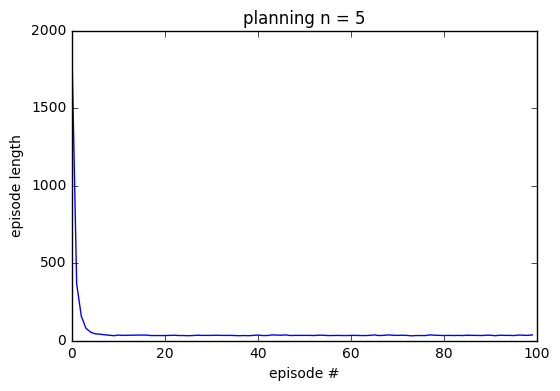

In [17]:
plt.plot(eps_lengths2)
plt.xlabel("episode #")
plt.ylabel("episode length")
plt.title("planning n = 5")

Let's also do it for $n = 50$.

In [18]:
eps_lengths3, q3 = repeat_experiment(env, 
    num_reps=10, num_eps=100, epsilon=0.1, alpha=0.1, model_n=50, gamma=0.95)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


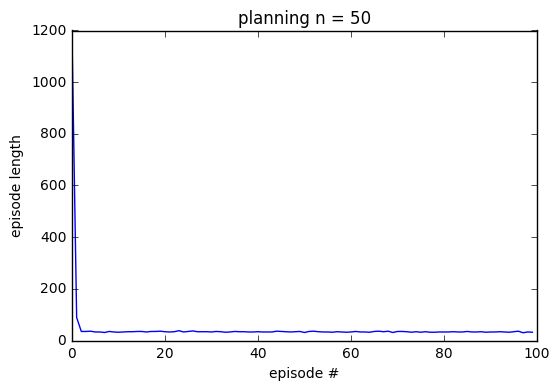

In [19]:
plt.plot(eps_lengths3)
plt.xlabel("episode #")
plt.ylabel("episode length")
plt.title("planning n = 50")

Let's plot them all together.

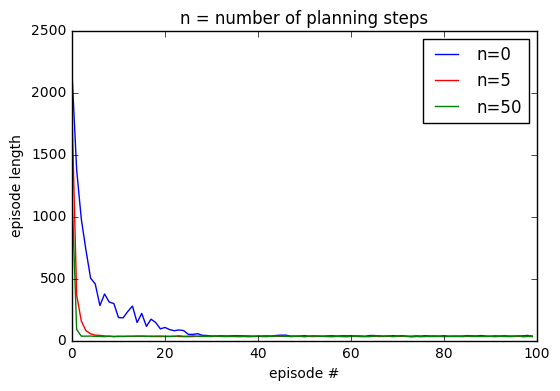

In [20]:
plt.plot(eps_lengths1, "b-", eps_lengths2, "r-", eps_lengths3, "g-")
plt.legend(["n=0","n=5","n=50"])
plt.xlabel("episode #")
plt.ylabel("episode length")
plt.title("n = number of planning steps")

We can see that simulating from experience does speed up our convergence!

## Dynamically changing maze

After this experiment, the authors presented another maze example in which there is a wall blocking the agent (except for one little grid square that is open) and after 1000 time steps the position of the wall changes. This is illustrated below.

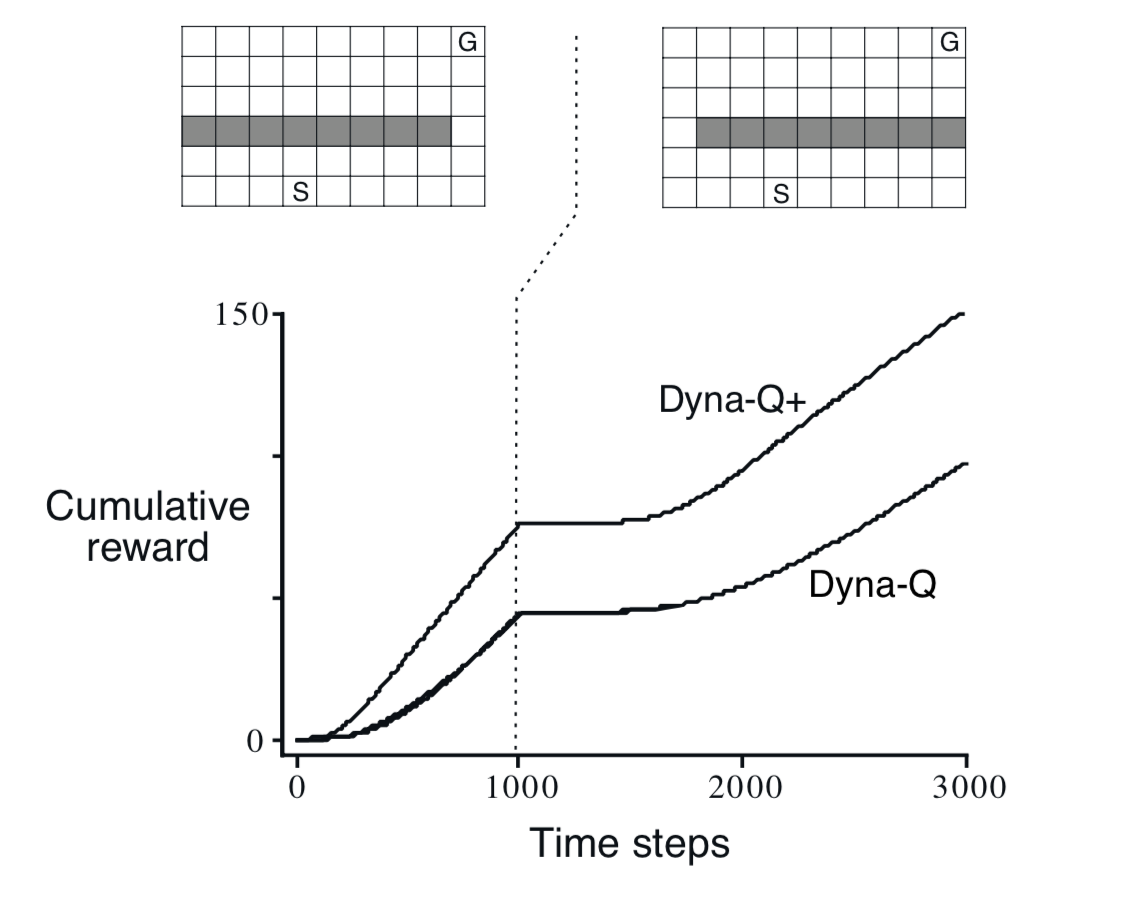

In [21]:
Image("./dyna_qplus.png", width=500)

The motivation behind this is that, once the wall changes position, our simulation model (from which we draw samples from) will no longer reflect the characteristics of the environment at that point in time, and that we must somehow be able to adapt to that.

The Dyna-Q+ agent is a simple modification to the Dyna-Q algorithm that keeps track, for each (state,action) pair, the number of time steps since that (state,action) pair was tried in a real interaction with the environment. If $\tau$ denotes the number of time steps elapsed, then in addition to the usual reward $r$, we get an extra reward $\kappa\sqrt{\tau}$, for some small $\kappa$. This encourages the model to try new (state,action) transitions that haven't been tried in a while, since the environment may have changed in the mean time and we need to account for that as quickly as possible.

In our implementation of the `q_learning` method we have some parameters we haven't used yet:
* `switch_env_after`: the ability to switch environment after a certain # of episodes (this is so we can switch the maze wall), and this is used in conjunction with the parameter `new_env`, which specifies the new environment
* `kappa`: add the option to turn on Dyna-Q+ (when `kappa = 0` Dyna-Q+ is turned off)
* `kappa_action_select`: we will get to this after this section, just ignore this for now!

This is the initial maze: the gap the agent needs to get through is on the right.

In [22]:
obstacles=[(3,0),(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7)]
env = Maze(shape=(6,9), obstacles=obstacles, goal=(0,8), start_state=(5,3))
env.render()

o o o o o o o o G 
o o o o o o o o o 
o o o o o o o o o 
X X X X X X X X o 
o o o o o o o o o 
o o o x o o o o o 


After some time, we want to switch to the new maze, where the wall shifts to the right and the gap is now on the left. The agent needs to learn that this is the new way to get to the goal state.

In [23]:
obstacles=[(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8)]
env_shifted = Maze(shape=(6,9), obstacles=obstacles, goal=(0,8), start_state=(5,3))
env_shifted.render()

o o o o o o o o G 
o o o o o o o o o 
o o o o o o o o o 
o X X X X X X X X 
o o o o o o o o o 
o o o x o o o o o 


We use the new arguments `new_env` and `switch_env_after` to switch to the new maze after episode 25 (for each repeat of the experiment).

In [24]:
eps_lengths4, q4 = repeat_experiment(env, 
    num_reps=10, num_eps=50, epsilon=0.1, alpha=0.1, model_n=5, gamma=0.95, new_env=env_shifted, switch_env_after=25)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


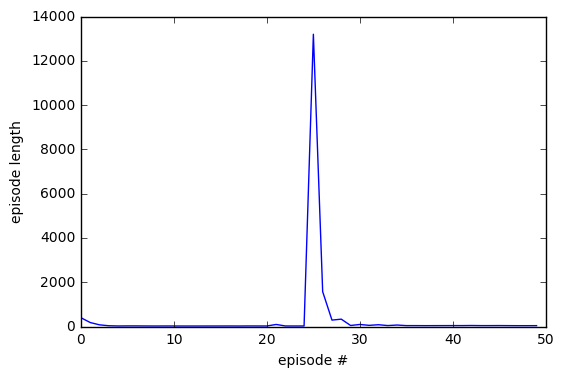

In [25]:
plt.plot(eps_lengths4)
plt.xlabel("episode #")
plt.ylabel("episode length")

Here we enable Dyna-Q+, and let $\kappa = 0.001$.

In [26]:
eps_lengths5, q5 = repeat_experiment(env, 
    num_reps=10, num_eps=50, epsilon=0.1, alpha=0.1, model_n=5, gamma=0.95, kappa=0.001, new_env=env_shifted, switch_env_after=25)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


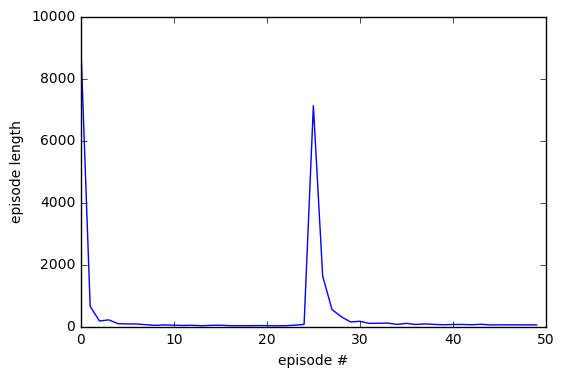

In [27]:
plt.plot(eps_lengths5)
plt.xlabel("episode #")
plt.ylabel("episode length")

$\kappa = 0.005$

In [28]:
eps_lengths6, q6 = repeat_experiment(env, 
    num_reps=10, num_eps=50, epsilon=0.1, alpha=0.1, model_n=5, gamma=0.95, kappa=0.005, new_env=env_shifted, switch_env_after=25)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


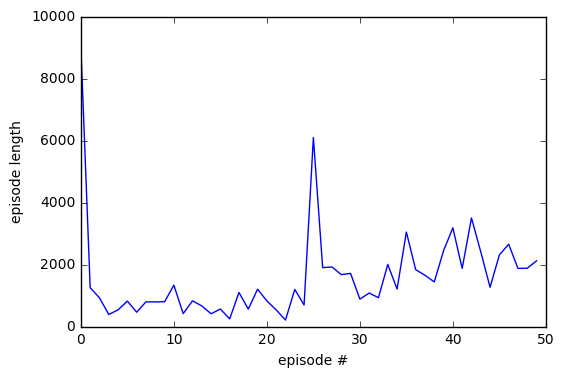

In [29]:
plt.plot(eps_lengths6)
plt.xlabel("episode #")
plt.ylabel("episode length")

Let's plot all the experiments together.

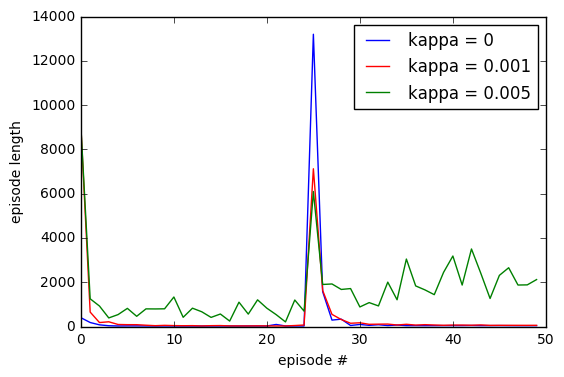

In [30]:
plt.plot(eps_lengths4,"b-",eps_lengths5,"r-",eps_lengths6,"g-")
plt.xlabel("episode #")
plt.ylabel("episode length")
plt.legend(["kappa = 0", "kappa = 0.001", "kappa = 0.005"])

We can see that setting $\kappa = 0.001$ has helped the agent recover more so than $\kappa = 0$. $\kappa = 0.005$ has as well, but it also suffers before and after the maze changed, as it seems to favour too much exploration.

If we compare the L2 norms of $\kappa = 0$ and $\kappa = 0.001$, we can see that the latter has a greater norm due to the bonus reward used in the backup.

In [31]:
np.sum(q5**2), np.sum(q4**2)

(51.836446992824165, 21.236124302136986)

## Extra exercise

The book asks this as an exercise to do:

"The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa \sqrt{\tau}$ was used not in backups, but solely in action selection. That is, suppose the action selected was always that for which $Q(S, a) + \kappa \sqrt{\tau}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach."

To test this, we have an extra parameter for our `q_learning` function:
* `kappa_action_select`: if set to true, then we don't use $\kappa \sqrt{\tau}$ in backups, only in action selection

Let's try this new setting, `kappa_action_select`, with different values of $\kappa \in \{0.001, 0.005, 0.01, 0.1\}$.

In [32]:
eps_lengths7, q7 = repeat_experiment(
    env, 
    num_reps=10, 
    num_eps=50, 
    epsilon=0.1, 
    alpha=0.1, 
    model_n=5, 
    gamma=0.95, 
    kappa=0.001,
    new_env=env_shifted,
    switch_env_after=25,
    kappa_action_select=True)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


In [33]:
eps_lengths8, q8 = repeat_experiment(
    env, 
    num_reps=10, 
    num_eps=50, 
    epsilon=0.1, 
    alpha=0.1, 
    model_n=5, 
    gamma=0.95, 
    kappa=0.005,
    new_env=env_shifted,
    switch_env_after=25,
    kappa_action_select=True)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


In [34]:
eps_lengths9, q9 = repeat_experiment(
    env, 
    num_reps=10, 
    num_eps=50, 
    epsilon=0.1, 
    alpha=0.1, 
    model_n=5, 
    gamma=0.95, 
    kappa=0.01,
    new_env=env_shifted,
    switch_env_after=25,
    kappa_action_select=True)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


In [35]:
eps_lengths10, q10 = repeat_experiment(
    env, 
    num_reps=10, 
    num_eps=50, 
    epsilon=0.1, 
    alpha=0.1, 
    model_n=5, 
    gamma=0.95, 
    kappa=0.1,
    new_env=env_shifted,
    switch_env_after=25,
    kappa_action_select=True)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env
episode 26, switching env to new env


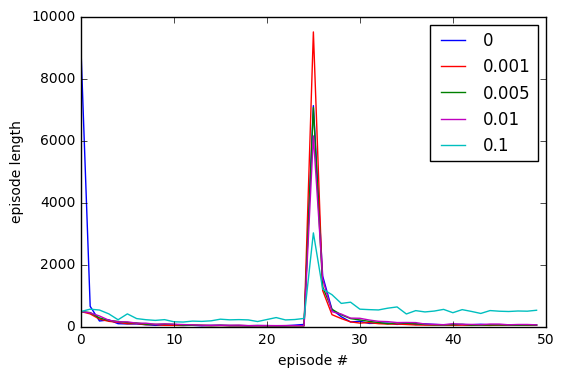

In [36]:
plt.plot(eps_lengths5, "b-", eps_lengths7, "r-", eps_lengths8, "g-", eps_lengths9, "m-", eps_lengths10, "c-")
plt.legend([0, 0.001, 0.005, 0.01, 0.1])
plt.xlabel("episode #")
plt.ylabel("episode length")

In this case, the $\kappa$ that performs the best recovery is $\kappa = 0.1$, but this is perhaps a bit too high since it does too much exploration (its average episode length is slightly higher than the over experiments when we consider the entire graph).

If we examine the L2 norms of the Q functions of $\kappa = 0.001, 0.005, 0.01, 0.1$, we get (respectively):

In [37]:
print np.sum(q7**2), np.sum(q8**2), np.sum(q9**2), np.sum(q10**2)

26.6547401451 29.9694364155 40.2416641687 80.8251898713


It looks like the Q values still change here, which I suppose is consistent with our understanding of generalised policy iteration, since we make $\pi$ consistent with $Q$, then we make $Q$ greedy w.r.t. $\pi$, and we go back and forth until convergence. The question asks if adding $\kappa \sqrt{\tau}$ to the backup is necessary, but from what we've seen, even if we use it in action selection (i.e. be $\epsilon$-greedy w.r.t. $Q + \kappa \sqrt{\tau}$) this is still going to change the final $Q$ function, so it seems 'necessary' that $Q$ be modified either way. **Note: I hope this is the right answer? Maybe I'm missing something here. If you're marking this assignment, do let me know otherwise!**